# Capstone Project - The Battle of Neighborhoods

**(1) Import libraries needed**

In [1]:
import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
from wordcloud import WordCloud, get_single_color_func

print('Libraries imported.')

Libraries imported.


**(2) Load Neighborhoods in New York and Toronto from:**

New York: https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json

Toronto: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

**(i) Download and load data from New York (US)**

In [2]:
# Download and load New York data

!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


**Let have a look at data in pandas dataframe**

In [3]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from Manhattan:

neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)

print('Number of neighborhoods found in the city of New York: ', neighborhoods_ny.shape[0])
neighborhoods_ny.head()

Number of neighborhoods found in the city of New York:  40


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


**(ii) Download and load data from Toronto (Canada)**

In [4]:
webPage = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

print('Data downloaded!')
print('Loading data...')

html = webPage.text                                                                       
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]

print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


**Let have a look at data in pandas dataframe**

In [41]:
table = pd.read_html(htmlTable, header = 0)[0]                                            
table["Borough"] = table["Borough"].replace({"Not assigned":np.nan})                
table.dropna(inplace = True)                                                          
table.where(table != "Not assigned", table["Borough"], axis = 0, inplace = True)  
table.rename(columns={"Neighbourhood": "Neighborhood"}, inplace = True)
table.head()

joinedRows = table.groupby("Postal Code")["Neighborhood"].apply(lambda x: ", ".join(x)) 
table.drop_duplicates(["Postal Code"],inplace = True)        

df = table.join(joinedRows, on = "Postal Code", lsuffix='_single')                       
df.drop(columns = ["Neighborhood_single"], inplace = True)                         
df.reset_index(drop = True, inplace = True)

In [42]:
# Add latitude and longitude from: http://cocl.us/Geospatial_data

!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data

geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_to = df.join(geo, on = "Postal Code")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)

print('Number of neighborhoods found in the city of Toronto: ', neighborhoods_to.shape[0])
neighborhoods_to.head()

Number of neighborhoods found in the city of Toronto:  39


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


**(3) Visualize the neighborhoods in New York and Toronto**

**(i) Get center coordinates to visualize both cities at the same time**

In [43]:
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent="http")

location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7896239, -73.9598939.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.

The geograpical central coordinates are 42.2215528, -76.6719143.


**(ii) Append NY and Toronto tables**

In [44]:
tmp = neighborhoods_to.drop("Postal Code", axis = 1)

df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
78,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


**(iii) Visualize both neighborhoods using folium**

In [45]:
map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

**New York city visualization**

In [117]:
map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

**Toronto visualization**

In [47]:
map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

**(4) Import data from Foursquare**

**(i) Set up the credentials**

In [48]:
CLIENT_ID = 'UGZ02U5FOWXHIWQAWWVMJ25DPLLSQ10WXESWA32G53FM1AGS' # your Foursquare ID
CLIENT_SECRET = 'VWINXOWSF0U2JHTFYFDQ1XQAGYK1LPWL1K1GM0FFARXFDWUI' # your Foursquare Secret
VERSION = '20200709'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UGZ02U5FOWXHIWQAWWVMJ25DPLLSQ10WXESWA32G53FM1AGS
CLIENT_SECRET:VWINXOWSF0U2JHTFYFDQ1XQAGYK1LPWL1K1GM0FFARXFDWUI


**(ii) Create and send the GET request**

https://api.foursquare.com/v2/venues/explore?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&radius=500&limit=LIMIT

In [49]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+str(name)+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)   

In [50]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Regent Park, Harbourfront
42 | Queen's Park, Ontario Provincial Government
43 | Garden District, Ryerson
44 | St. James Town
45 | The Beaches
46 | Berczy Park
47 | Central Bay Street
48 | Christie
49 | Richmond, Adelaide, King
50 | Dufferin, Dovercourt Village
51 | Harbourfront East, Uni

**(iii) One hot encoding and grouping by neighborhoods**

In [51]:
# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.013699,0.0,0.000000,0.000000
1,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,"Brockton, Parkdale Village, Exhibition Place",West Toronto,43.636847,-79.428191,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Washington Heights,Manhattan,40.851903,-73.936900,0.011628,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.011628,0.023256,0.0,0.011628,0.000000
77,West Village,Manhattan,40.734434,-74.006180,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.040000,0.000000,0.0,0.000000,0.000000
78,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.01,0.02,0.0,0.0,0.0,0.010000,0.030000,0.0,0.000000,0.000000


**(5) Clustering**

**(i) Find centroids with K-means**

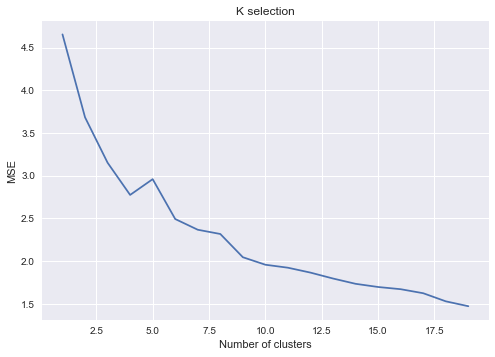

In [54]:
# Finding best k
plt.style.use("seaborn")
Ks = 20
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

According to the elbow method, 5 clusters are enough for finding similarities!.

In [170]:
# set number of clusters
kclusters = 8
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,1
1,Manhattan,Chinatown,40.715618,-73.994279,5
2,Manhattan,Washington Heights,40.851903,-73.936900,5
3,Manhattan,Inwood,40.867684,-73.921210,1
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4
5,Manhattan,Manhattanville,40.816934,-73.957385,1
6,Manhattan,Central Harlem,40.815976,-73.943211,5
7,Manhattan,East Harlem,40.792249,-73.944182,1
8,Manhattan,Upper East Side,40.775639,-73.960508,1
9,Manhattan,Yorkville,40.775930,-73.947118,1


**(ii) Display clusters in map**

In [171]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [172]:
# create map of New York City
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [173]:
# create map for Toronto
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

**(iii) Analyze Centroids**

CLUSTER 1

In [174]:
cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

,Neighborhood
45,Berczy Park


CLUSTER 2

In [175]:
cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

,Neighborhood
0,Marble Hill
3,Inwood
5,Manhattanville
7,East Harlem
8,Upper East Side
9,Yorkville
12,Upper West Side
13,Lincoln Square
17,Chelsea
18,Greenwich Village


CLUSTER 3

In [176]:
pd.set_option('max_rows', 100)
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

,Neighborhood
51,"Little Portugal, Trinity"


CLUSTER 4

In [177]:
cl4 = tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl4

,Neighborhood
56,"Commerce Court, Victoria Hotel"


CLUSTER 5

In [178]:
cl5 = tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl5

,Neighborhood
4,Hamilton Heights
11,Roosevelt Island
24,West Village
43,St. James Town
44,The Beaches
49,"Dufferin, Dovercourt Village"
53,"Toronto Dominion Centre, Design Exchange"
58,Lawrence Park
62,"High Park, The Junction South"
67,"University of Toronto, Harbord"


In [179]:
cl6 = tony_merged.loc[tony_merged['Cluster Labels'] == 5, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl6

,Neighborhood
1,Chinatown
2,Washington Heights
6,Central Harlem
10,Lenox Hill
14,Clinton
20,Lower East Side
21,Tribeca
28,Battery Park City
42,"Garden District, Ryerson"
52,"The Danforth West, Riverdale"


In [180]:
cl7 = tony_merged.loc[tony_merged['Cluster Labels'] == 6, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl7

,Neighborhood
15,Midtown
16,Murray Hill
66,Davisville


In [181]:
cl8 = tony_merged.loc[tony_merged['Cluster Labels'] == 7, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl8

,Neighborhood
23,Soho
34,Sutton Place
55,"India Bazaar, The Beaches West"


**(6) Data visualization**

**(i)  Waffle Chart**

In [182]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,8)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 500
Cluster I: 70
Cluster II: 6
Cluster III: 6
Cluster IV: 278
Cluster V: 6
Cluster VI: 95
Cluster VII: 19
Cluster VIII: 19


<Figure size 576x396 with 0 Axes>

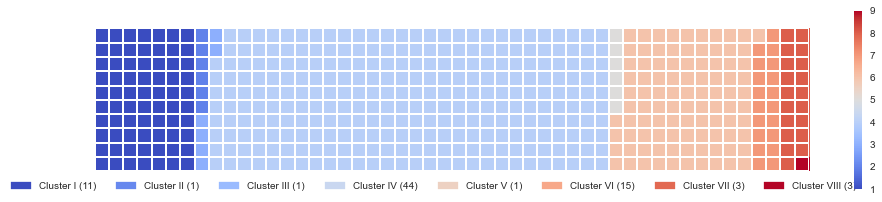

In [183]:
index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V', 'Cluster VI', 'Cluster VII', 'Cluster VIII']
portions = [cl5.shape[0], cl1.shape[0], cl4.shape[0], cl2.shape[0], cl3.shape[0], cl6.shape[0], cl7.shape[0], cl8.shape[0]]
width = 50 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)

**(ii) Word Cloud**

In [143]:
word_string = ""
for neighborhood in tony_merged["Neighborhood"]:
    elements = ""
    for element in neighborhood.split(","):
        elements += element.strip().replace(" ", "") + " "
    word_string += elements+" "
word_string = word_string.replace(".","")

tmp = cl1["Neighborhood"].tolist()
cl1_list = []
for element in tmp:
    cl1_list.extend(element.split(", "))
cl1_list = [element.replace(" ","") for element in cl1_list]

tmp = cl2["Neighborhood"].tolist()
cl2_list = []
for element in tmp:
    cl2_list.extend(element.split(", "))
cl2_list = [element.replace(" ","") for element in cl2_list]
    
tmp = cl3["Neighborhood"].tolist()
cl3_list = []
for element in tmp:
    cl3_list.extend(element.split(", "))
cl3_list = [element.replace(" ","") for element in cl3_list]
cl3_list = [element.replace(".","") for element in cl3_list]

tmp = cl4["Neighborhood"].tolist()
cl4_list = []
for element in tmp:
    cl4_list.extend(element.split(", "))
cl4_list = [element.replace(" ","") for element in cl4_list]    

tmp = cl5["Neighborhood"].tolist()
cl5_list = []
for element in tmp:
    cl5_list.extend(element.split(", "))
cl5_list = [element.replace(" ","") for element in cl5_list]

tmp = cl6["Neighborhood"].tolist()
cl6_list = []
for element in tmp:
    cl6_list.extend(element.split(", "))
cl6_list = [element.replace(" ","") for element in cl6_list]

tmp = cl7["Neighborhood"].tolist()
cl7_list = []
for element in tmp:
    cl7_list.extend(element.split(", "))
cl7_list = [element.replace(" ","") for element in cl7_list]

tmp = cl8["Neighborhood"].tolist()
cl8_list = []
for element in tmp:
    cl8_list.extend(element.split(", "))
cl8_list = [element.replace(" ","") for element in cl8_list]



Word cloud created!


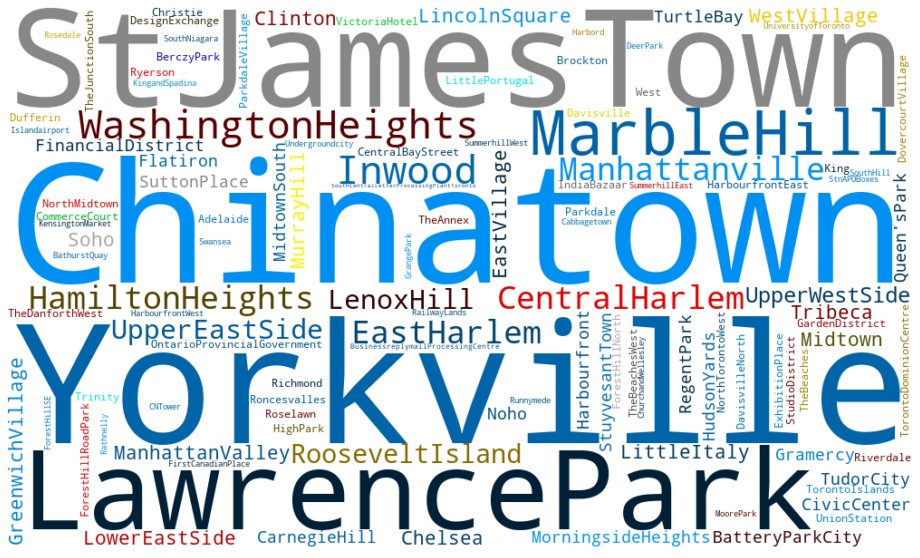

In [184]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words = 500).generate(word_string)

color_to_words = {
    # words below will be colored with a green single color function
    '#0000FF': cl1_list,
    # will be colored with a red single color function
    '#0099FF': cl2_list,
    '#00FFFF': cl3_list,
    '#00FF33': cl4_list,
    '#FFCC00': cl5_list,
    '#FF0000': cl6_list,
    '#FFFF00': cl7_list,
    '#000000': cl8_list
}

default_color = 'grey'

print('Word cloud created!')

fig = plt.figure()
fig.set_figwidth(500)
fig.set_figheight(10)

grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**(iii) Bar chart for clusters insight**

In [145]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[2,:]
tmp[5,:] = kmeans.cluster_centers_[5,:]
tmp[6,:] = kmeans.cluster_centers_[6,:]
tmp[7,:] = kmeans.cluster_centers_[7,:]
maxi = []
for i in range(8):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V', 'Cluster VI', 'Cluster VII', 'Cluster VIII'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

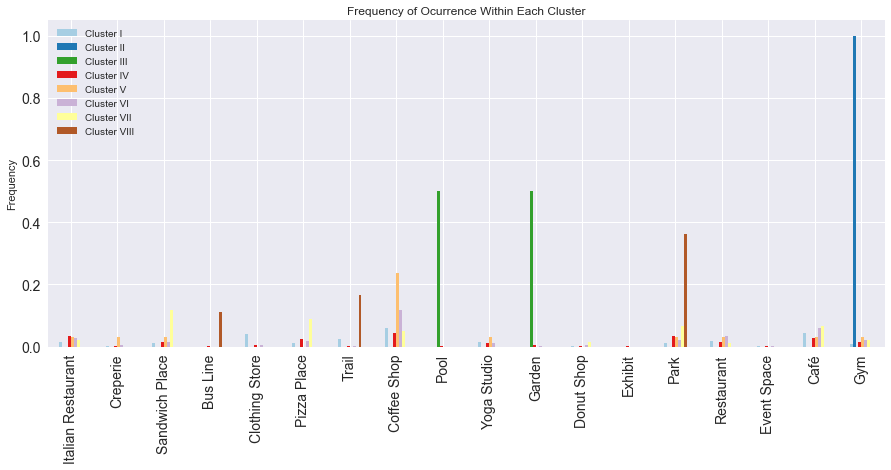

In [146]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [147]:
maxi = []
for i in range(8):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V', 'Cluster VI', 'Cluster VII', 'Cluster VIII'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.T
table.drop(["Gym"], inplace= True)

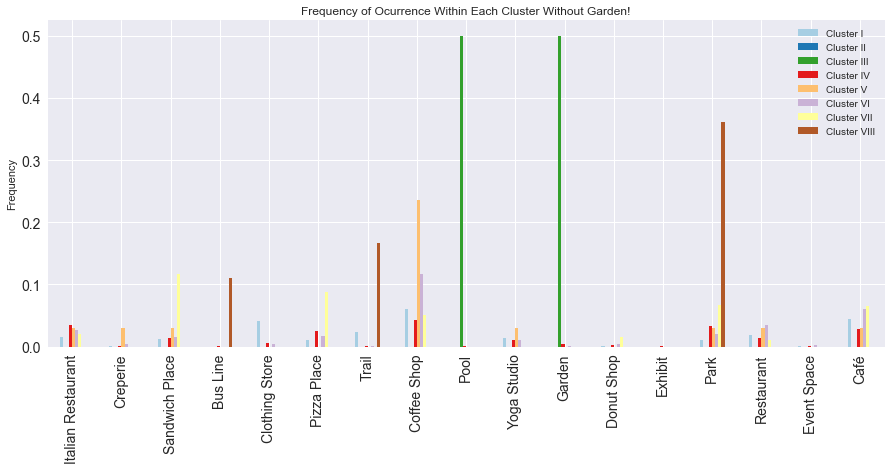

In [148]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = "Paired")
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster Without Garden!")
plt.ylabel("Frequency")
plt.show()